## Smoothing the Data using Kalman Filtering

Applies Kalman Filtering to the raw 297/58/53 town data as it was quite noisy. Took a few (too many) goes to get working, but finally does a good job. Have still kept the individual Kalman filtering in there just for reference.

In [1]:
# Import the many necessary libraries
import pandas as pd
import os
import numpy as np
import filterpy as fp
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import math
import networkx as nx
import time
import scipy

In [2]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from scipy.sparse import identity
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

First, create a dictionary where each entry is a dataframe of the adjacency matrix.

In [178]:
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/44_<250_network/"))

In [179]:
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)

In [180]:
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/44_<250_network/"+wa_flow[i], header = None)

In [181]:
len(d)

97

In [182]:
len(wa_flow)

97

In [183]:
# Define some global variables
b = 44
big = 44**2
weeks = len(d)

Create a list (allvals) which includes every value from every dataframe as one long list

In [184]:
allvals = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals.append(k)

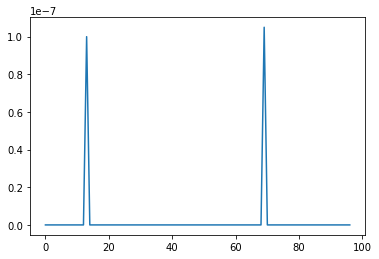

In [185]:
#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals[x+(big)*i])
    return timeseries
ts = timeseries_vector(15*44+26)
plt.plot(ts)

**Individual (edge by edge) Kalman Filter:**

This Kalman filter treats the time series of each edge as an individual entity and does a Kalman filter on that.

In [186]:
def kalman_gain(r,q, kalmans):
    # Kalman gain formula
    prev = kalmans[-1]
    kalmans.append( ((prev + q)**(-1)+1/r)**(-1) )
    return kalmans

In [187]:
mean = np.mean(allvals)
std = np.std(allvals)

In [188]:
def filtering(timeseries,r,q,mean,std):
    updated = [np.mean(timeseries)]
    inn = []
    kg = [((std**2 + q)**(-1) + 1/r)**(-1)]
    for t in timeseries:
        kg = kalman_gain(r,q,kg)
        
        # Updating of the data formula
        up = updated[-1] + kg[-1]*(r)**(-1)*(t - updated[-1])
        
        inn.append(t-updated[-1])
        updated.append(up)
        
    updated = updated[1:]
    return updated, kg, inn

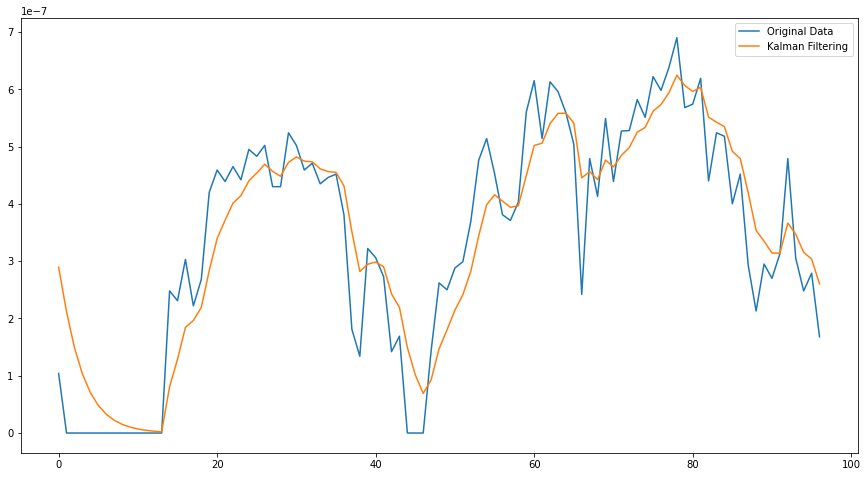

In [189]:
# E.g. just one edge
ts = timeseries_vector(7)
plt.figure(figsize = (15,8))
plt.plot(ts, label = 'Original Data')
f, kg, inn = filtering(ts, 2, 0.3, mean, std)
plt.plot(f, label = 'Kalman Filtering')
plt.legend()

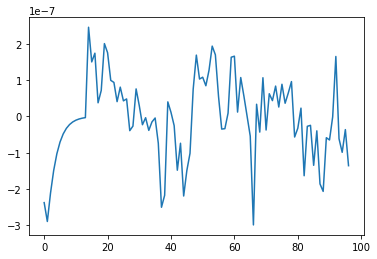

In [190]:
#Plot the innovations and make sure that they oscillate or at least don't converge.
plt.figure()
plt.plot(inn)

In [191]:
#Run a Kalman on each edge:
allkal = []
for i in range(big):
    ts = timeseries_vector(i)
    if all(0 == t for t in timeseries_vector(i) ): 
        #Check: if all 0's, just keep it as all 0's rather than a value that asymptotically approaches 0.
        f = [0]*weeks
    else:
        f, kg, inn = filtering(ts, 2, 0.3, mean, std)
    allkal.append(f)

In [192]:
# Rearrange the allkal so that it's in the adjacency matrix formation that it was before
new_data = []
for j in range(weeks):
    n = []
    for i in range(b):
        nd = []
        for k in range(b):
            nd.append(allkal[i*b+k][j])
        n.append(nd)
    new_data.append(n)

In [193]:
# Write in to the file.
for j in range(weeks):
    df = pd.DataFrame(new_data[j])
    df.to_csv("/Volumes/HardDrive/New_Workflow/kalman_individual_44_<250/"+wa_flow[j],sep = '\t',index = False, header = False)

## All to All Covariance

Now it uses the Pearson Correlation between two edges as the intialisation of the all to all covariance matrix. Means edges actually have an effect on each other (but note it still approximates the individual case pretty well).

In [194]:
I = identity(big)

In [195]:
# Initialise the starting points
w = d['0'].copy()
for i in range(1,len(d.keys())):
    w += d[str(i)].copy()

# w is then the mean flow over all weeks
w = w/weeks
w.to_numpy()
w = w.values.tolist()
observ = []
for i in w:
    for j in i:
        observ.append(j)
# observ is a one big list representation of w

In [237]:
# Initialise the covariance matrix which we will later define elementwise.
R = lil_matrix((big,big))

In [273]:
# Iterate over all edges
for edge in range(big):
    print(edge)
    # Get the timeseries of each edge
    ts = timeseries_vector(edge)
    if np.all(np.array(ts)==0):
        continue
        # Ignore if it's just all 0s
    else:
        # Otherwise, get another edge
        for edgep in range(edge+1,big):
            tsp = timeseries_vector(edgep)
            if np.all(np.array(tsp)==0):
                continue
                # Again, ignore if it's all 0s
            else:
                # Otherwise compute the pearson correlation of the two timeseries and write it into R
                r = ((scipy.stats.pearsonr(ts,tsp))[0])**2
                if r > 0:
                    R[edge,edgep] = r
                    R[edgep,edge] = r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

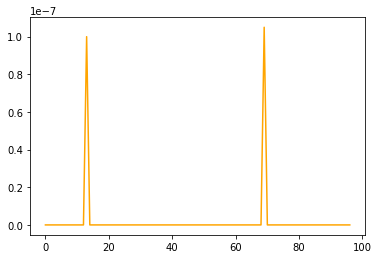

In [349]:
ts = timeseries_vector(316)
tsp = timeseries_vector(686)
plt.plot(tsp, color = 'orange')
#plt.plot(tsp)

In [340]:
ii = []
for i in range(big):
    point = 0
    ts = timeseries_vector(i)
    for t in ts:
        if t > 0:
            point+=1
    if (point/len(ts) < 0.021) and (point/len(ts)>0.013):
        print(i, edges[i])
        ii.append(i)

5 Perth to Busselton
27 Perth to Waroona
127 Geraldton to Kalbarri
686 Carnarvon to Exmouth
726 Narrogin to Merredin
1444 Moora to Jurien Bay
1718 Kalbarri to Geraldton
1860 Augusta to Margaret River


In [329]:
fg = timeseries_vector(686)
point = 0
for t in fg:
    if t > 0:
        point+=1
point/len(fg)

0.020618556701030927

In [338]:

#for i in range(15*44,16*44):
allsum = []
for compar in ii:
    summ = []
    for i in range(big):
        if R[i,compar] > 0:
            summ.append(R[i,compar])
    allsum.append(sum(summ))
    print(compar, edges[compar], sum(summ))
            #print(R[i,compar],i,compar)
            #carn.append(R[i,compar])
            #.append(i)
            #plt.plot(timeseries_vector(i))
            #plt.ylim(0,0.0000005)
        #R[i,686] = 0
        #R[686,i] = 0
#plt.plot(carn)
print()

5 Perth to Busselton 7.9575667808866
27 Perth to Waroona 15.530772535719901
127 Geraldton to Kalbarri 1.695275437650432
686 Carnarvon to Exmouth 0.4458143718197536
726 Narrogin to Merredin 1.8739342293466597
1444 Moora to Jurien Bay 4.779407003336058
1718 Kalbarri to Geraldton 8.319712135212216
1860 Augusta to Margaret River 14.53914418977443



In [342]:
#for i in range(15*44,16*44):
for compar in ii:
    diff = []
    for i in range(big):
        if R[i,compar] > 0.1:
            ts = timeseries_vector(i)
            diff.append(ts[1]-ts[0])
    print(compar,edges[compar], sum(diff))

5 Perth to Busselton -1.0019771645874886e-06
27 Perth to Waroona -1.3679640505110689e-06
127 Geraldton to Kalbarri 0.0
686 Carnarvon to Exmouth 0
726 Narrogin to Merredin 0.0
1444 Moora to Jurien Bay -1.4599404554618538e-07
1718 Kalbarri to Geraldton -9.459822882685446e-07
1860 Augusta to Margaret River -1.3339663051789413e-06


In [332]:
ii

[5, 27, 127, 686, 726, 1444, 1718, 1860]

In [264]:
297-6*44

33

In [345]:
for i in range(big):
    ts = timeseries_vector(i)
    if (ts[1] > 0) and (ts[0]>0):
        div = ts[1]/ts[0]
        if div > 1.5:
            print(i)

In [265]:
# The R matrix then becomes our initial Sig 
Sig = csc_matrix(R)

# We arbitrarily choose the diagonal value to be twice as large as the mean of R.
diag = 2*np.mean(Sig)
for edge in range(big):
    R[edge,edge] = diag
Sig = csc_matrix(R)

In [266]:
diag

0.0007782661176444332

In [267]:
Sig

<1936x1936 sparse matrix of type '<class 'numpy.float64'>'
	with 17678 stored elements in Compressed Sparse Column format>

In [268]:
def kalman_gain_all(r,q,kalman):
    # Define the kalman gain equation
    kg = inv(inv(kalman + q*I)+(1/r)*I)
    return kg

In [321]:
def filtering_all(r,q,cov,start):
    updated = [start] # First observations
    kg = cov # Sig
    inn = []
    # Iterate over all weeks
    for i in range(1,weeks):
        t = time.time()
        # Get the new Kalman gain
        kg = kalman_gain_all(r,q,kg)
        prev = updated[-1]
        gain = kg.dot((1/r)*I)
        vals = allvals[i*big:(i+1)*big] # Get the relevant week
        innov = csc_matrix(vals) - csc_matrix(prev)
        # Update the observation based on Kalman filtering
        up = np.transpose(csc_matrix(prev).toarray()) + gain.dot(np.transpose(innov.toarray()))
        upp = []
        for u in up:
            for j in u:
                if j < 0: # Ignore any below 0 entries as it's not physical
                    upp.append(0)
                else:
                    upp.append(j)
        updated.append(upp)
        e = time.time()
        print(i,e-t)
    #updated = updated[1:]
    return updated

In [313]:
up = filtering_all(diag*2,diag/5,Sig,observ) #Run the function!

1 0.9651331901550293
2 0.9358580112457275
3 0.8609821796417236
4 0.8904821872711182
5 0.8620460033416748
6 0.856652021408081
7 0.8858718872070312
8 0.9707677364349365
9 0.9516441822052002
10 0.8807122707366943
11 0.8970510959625244
12 0.8604240417480469
13 0.8603379726409912
14 0.8644471168518066
15 0.864264965057373
16 0.8722491264343262
17 0.8646647930145264
18 0.9278390407562256
19 0.8631391525268555
20 0.8896276950836182
21 0.9691958427429199
22 1.0061390399932861
23 0.995668888092041
24 0.9252429008483887
25 0.9574470520019531
26 0.9340810775756836
27 0.8859529495239258
28 1.0411591529846191
29 0.9462151527404785
30 0.9692590236663818
31 1.0081794261932373
32 1.002568244934082
33 0.9773600101470947
34 1.0254881381988525
35 1.000648021697998
36 0.9604270458221436
37 0.9075629711151123
38 0.889495849609375
39 0.922874927520752
40 0.8791379928588867
41 0.8797900676727295
42 1.3423528671264648
43 3.6765310764312744
44 1.790524959564209
45 1.0813241004943848
46 0.9246630668640137
47 0.

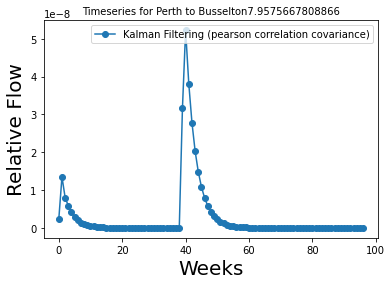

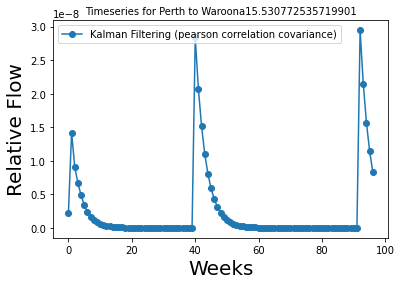

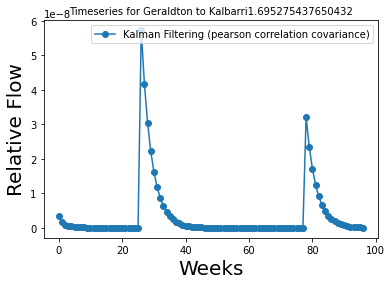

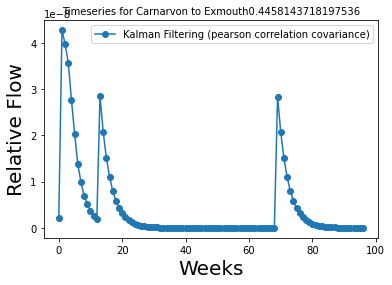

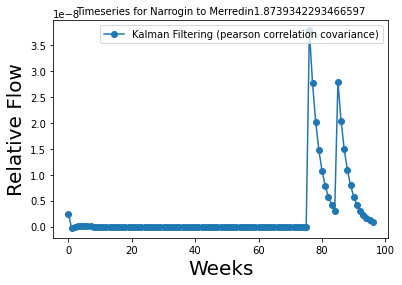

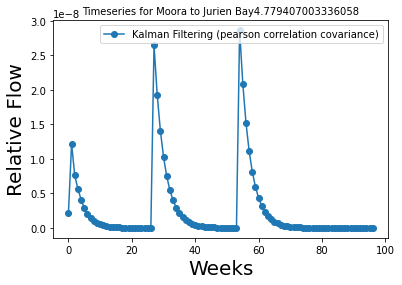

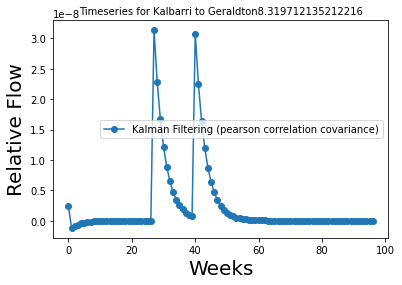

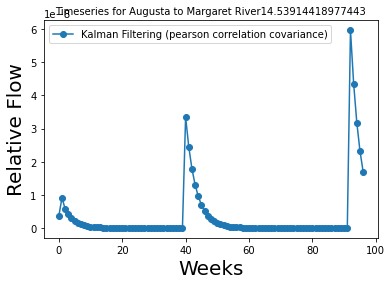

In [319]:
# Check some differenct edges and plot to see what you get!
#v = 15*44+26
for k in range(len(ii)):
    v = ii[k]
    ts = timeseries_vector(v)
    plt.figure(figsize = (6,4))
    #plt.plot(ts, label = 'Original Data')
    fil = []
    for i in range(weeks):
        fil.append(up[i][v])
    plt.plot(fil, marker ='o',label = 'Kalman Filtering (pearson correlation covariance)')
    #f, kg, inn = filtering(ts, diag*2,diag/5, mean, std)
    #plt.plot(f, color = 'black',label = 'Kalman Filtering (identity covariance)')
    plt.title('Timeseries for '+edges[ii[k]]+ str(allsum[k]), fontsize = 10)
    plt.xlabel('Weeks', fontsize = 20)
    plt.ylabel('Relative Flow',fontsize = 20)
    #plt.ylim(0,0.00000015)
    plt.legend()

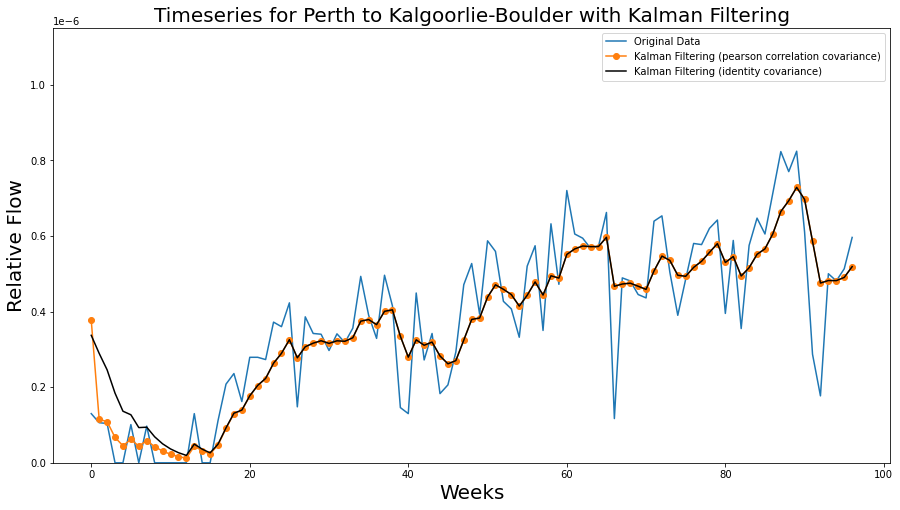

In [208]:
# Check some differenct edges and plot to see what you get!
v = 3
ts = timeseries_vector(v)
plt.figure(figsize = (15,8))
plt.plot(ts, label = 'Original Data')
fil = []
for i in range(weeks):
    fil.append(up[i][v])
plt.plot(fil, marker ='o',label = 'Kalman Filtering (pearson correlation covariance)')
f, kg, inn = filtering(ts, diag*2,diag/5, mean, std)
plt.plot(f, color = 'black',label = 'Kalman Filtering (identity covariance)')
plt.title('Timeseries for Perth to Kalgoorlie-Boulder with Kalman Filtering', fontsize = 20)
plt.xlabel('Weeks', fontsize = 20)
plt.ylabel('Relative Flow',fontsize = 20)
plt.ylim(0,0.00000115)
plt.legend()

In [320]:
# Check there are no negative entries remaining
for v in range(big):
    for i in range(weeks):
        if up[i][v] < 0:
            print(v,i, up[i][v])

2 1 -1.861366696353589e-08
2 2 -1.253137290919625e-08
2 3 -9.5241434848648e-09
2 4 -6.654153984774737e-09
2 5 -4.727097467965521e-09
2 6 -3.200638145343685e-09
2 7 -2.3026930300350817e-09
2 8 -1.6223168203677307e-09
2 9 -1.1921912406958638e-09
2 10 -8.551574071065444e-10
2 11 -6.245470721034813e-10
2 12 -4.5367340051450044e-10
2 13 -3.303335108726831e-10
2 14 -2.403802505471717e-10
2 15 -1.7604144650085095e-10
2 16 -1.2835745770292214e-10
2 17 -9.3456429599407e-11
2 18 -6.824589029621502e-11
2 19 -4.9782483599630955e-11
2 20 -3.632906674768506e-11
2 21 -2.6498609140096107e-11
2 22 -1.9345852997559307e-11
2 23 -1.4118981330658472e-11
2 24 -1.030302343733364e-11
2 25 -7.518555203385228e-12
2 26 -5.487580173109416e-12
2 27 -4.005074334350909e-12
2 28 -2.9232779142826555e-12
2 29 -2.133440596986723e-12
2 30 -1.557123869727327e-12
2 31 -1.136449505806476e-12
2 32 -8.294261770814155e-13
2 33 -6.053548099505732e-13
2 34 -4.418145271172866e-13
2 35 -3.2245592287694967e-13
2 36 -2.3534083496471

708 17 -9.808753259911926e-11
708 18 -7.16440859539211e-11
708 19 -5.226968137342958e-11
708 20 -3.814882953889879e-11
708 21 -2.7826843173094234e-11
708 22 -2.0316498933194117e-11
708 23 -1.4828174140495665e-11
708 24 -1.0820668795666875e-11
708 25 -7.89640349397061e-12
708 26 -5.7633650518041725e-12
708 27 -4.206342696980791e-12
708 28 -3.0701802020291006e-12
708 29 -2.2406469178420107e-12
708 30 -1.6353733399350853e-12
708 31 -1.1935547044774258e-12
708 32 -8.711045062651249e-13
708 33 -6.35773096028697e-13
708 34 -4.640154437863596e-13
708 35 -3.3865877409377597e-13
708 36 -2.471660990583917e-13
708 37 -1.8039200544528827e-13
708 38 -1.3165809848163984e-13
726 1 -2.5907247286870585e-10
726 2 -9.458100564339344e-11
744 1 -2.0625532718860622e-08
744 2 -1.2626636925926479e-08
744 3 -9.240359333412385e-09
744 4 -6.603633296636248e-09
744 5 -4.654949823744057e-09
744 6 -3.18145604279096e-09
744 7 -2.27539964448134e-09
744 8 -1.6044315396223375e-09
771 1 -1.6601775578532383e-08
771 2 -1.

1299 9 -2.661438261243911e-10
1408 1 -4.038243915676513e-08
1408 2 -2.4916641972121534e-08
1408 3 -1.814372758007415e-08
1408 4 -1.29420115851009e-08
1408 5 -9.098337286849003e-09
1408 6 -6.229001037516329e-09
1408 7 -4.457458415536231e-09
1408 8 -3.1413560581043566e-09
1408 9 -2.2891888187407393e-09
1408 10 -1.6471967164047274e-09
1408 11 -1.2017891386097449e-09
1408 12 -8.731421801966861e-10
1408 13 -6.343807659883348e-10
1408 14 -4.620341164215184e-10
1408 15 -3.3816781805650884e-10
1408 16 -2.4668839257584463e-10
1408 17 -1.7964912847227312e-10
1408 18 -1.3120622254864146e-10
1408 19 -9.572109344088287e-11
1408 20 -6.986092352824398e-11
1408 21 -5.095903200837057e-11
1408 22 -3.72044067100017e-11
1408 23 -2.7153248163361178e-11
1408 24 -1.9814763859445022e-11
1408 25 -1.4459930280202776e-11
1408 26 -1.0553876675102756e-11
1408 27 -7.70267684579053e-12
1408 28 -5.622092710246592e-12
1408 29 -4.103060243075873e-12
1509 1 -9.267643235987233e-10
1586 1 -4.520776333733032e-09
1586 2 -2.

1917 27 -1.8865977352909746e-12
1917 28 -1.3770341529559598e-12
1917 29 -1.0049621318560487e-12
1917 30 -7.334942921353686e-13
1917 31 -5.353305451549772e-13
1917 32 -3.907049526727746e-13
1917 33 -2.851550677482559e-13
1917 34 -2.0811873737637773e-13
1917 35 -1.518942669743549e-13
1917 36 -1.1085815187236145e-13
1917 37 -8.090881847302116e-14
1917 38 -5.905088073142051e-14
1917 39 -4.309799121165142e-14
1917 40 -3.14548509797571e-14
1917 41 -2.2957114549623595e-14
1917 42 -1.675511885464252e-14
1917 43 -1.2228625391029219e-14
1917 44 -8.924993587644083e-15
1917 45 -6.513854577623448e-15
1917 46 -4.754094365826367e-15
1917 47 -3.469745282877662e-15
1917 48 -2.532372000059547e-15
1917 49 -1.8482358758560925e-15
1917 50 -1.3489234113101694e-15
1917 51 -9.845033035849539e-16
1917 52 -7.185336083105337e-16
1919 2 -3.336371934304534e-11


In [32]:
# Rearrange data into the usable form, write it all into the files
new_data = []
for j in range(weeks):
    n = []
    for i in range(b):
        nd = []
        for k in range(b):
            nd.append(up[j][i*b+k])
        n.append(nd)
    new_data.append(n)

for j in range(weeks):
    df = pd.DataFrame(new_data[j])
    df.to_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44_<250/"+wa_flow[j],index = False, header = False)

**Checking the sum of all edges every week:**

In [8]:
weekdates = []
for name in wa_flow:
    weekdates.append(name[16:18]+'/'+name[14:16])

In [9]:
months = []
for name in wa_flow:
    m = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    mo = int(name[14:16])
    ye = int(name[12:14])
    
    date = str(m[mo-1]) + ' ' + str(ye)
    if date in months:
        months.append('')
    else:
        months.append(date)

In [11]:
weeks = 97

Text(0.5, 0, 'Date')

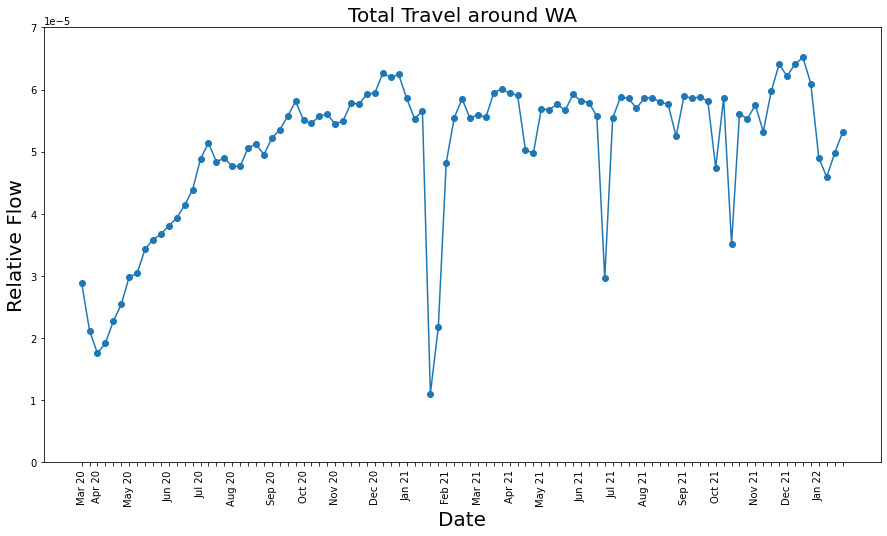

In [13]:
summ = []
for i in range(weeks):
    a = 0
    for j in d[str(i)].values.tolist():
        for k in j:
            a += k
    summ.append(a)
plt.figure(figsize = (15,8))
plt.plot(summ, marker = 'o')
plt.title('Total Travel around WA',fontsize = 20)
plt.ylim(0,0.00007)
plt.ylabel('Relative Flow', fontsize = 20)
plt.xticks([i for i in range(len(weekdates))],months,rotation = 90,fontsize = 10)
plt.xlabel('Date', fontsize = 20)

In [14]:
# Use this if just needing to plot results of Kalman filtering.

In [19]:
import networkx as nx
from numpy import genfromtxt

In [20]:
# Function to read in a text file into an array
def readFile(fileName):
        fileObj = open(fileName, "r") #opens the file in read mode
        words = fileObj.read().splitlines() #puts the file into an array
        arr = []
        for item in words:
            arr.append(item.split('\t'))
        fileObj.close()
        return arr

In [21]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]
# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring 0 flow towns
waloc = waloc.loc[(waloc['City / Town'] != 'Kununurra') & (waloc['City / Town'] != 'Derby') &
                  (waloc['City / Town'] != 'Boddington-Ranford') & (waloc['City / Town'] != 'Wyndham')]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])


# Read in the network, generate a plot for it
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/44_towns_network/Town_Flow_20200322_20200328.csv', delimiter=',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Assign labels to each town based on waloc
#towns = [item[0] for item in waloc]
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]
    
towns = list(labeldict.values())
edges = []
for t in towns:
    for o in towns:
        edges.append(t +' to ' + o)

In [24]:
for i in range(0,1000):
    point = 0
    ts = timeseries_vector(i)
    for t in ts:
        if t > 0:
            point+=1
    if point/len(ts) > 0.5:
        print(i, edges[i])

3 Perth to Kalgoorlie-Boulder
6 Perth to Karratha
7 Perth to Broome
8 Perth to Port Hedland
11 Perth to Northam
14 Perth to Newman
19 Perth to Tom Price
37 Perth to Paraburdoo
43 Perth to Mandurah
49 Bunbury to Busselton
54 Bunbury to Collie
65 Bunbury to Harvey
69 Bunbury to Donnybrook
72 Bunbury to Capel
108 Geraldton to Port Denison-Dongara
132 Kalgoorlie-Boulder to Perth
162 Kalgoorlie-Boulder to Kambalda West
199 Albany to Denmark
207 Albany to Little Grove
221 Busselton to Bunbury
233 Busselton to Dunsborough
248 Busselton to Capel
254 Busselton to Cowaramup
264 Karratha to Perth
297 Karratha to Wickham
308 Broome to Perth
352 Port Hedland to Perth
441 Collie to Bunbury
484 Northam to Perth
508 Northam to York
562 Margaret River to Cowaramup
577 Dunsborough to Busselton
616 Newman to Perth
635 Newman to Tom Price
773 Manjimup to Donnybrook
832 Katanning to Kojonup
836 Tom Price to Perth
850 Tom Price to Newman
873 Tom Price to Paraburdoo
882 Port Denison-Dongara to Geraldton
925 

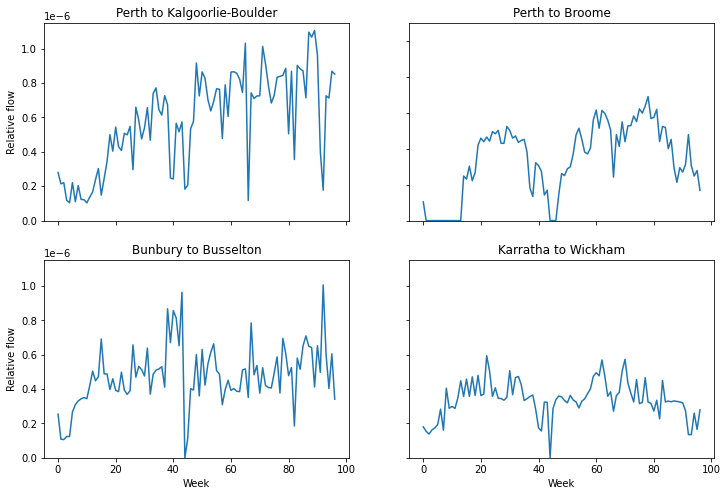

In [27]:
fig, axs = plt.subplots(2, 2,figsize = (12,8))
ts = timeseries_vector(3)
axs[0, 0].plot(ts)
axs[0, 0].set_title('Perth to Kalgoorlie-Boulder')
axs[0, 0].set_ylim(0,0.00000115)
ts = timeseries_vector(7)
axs[0, 1].plot(ts)
axs[0, 1].set_title('Perth to Broome')
axs[0, 1].set_ylim(0,0.0000011)
ts = timeseries_vector(49)
axs[1, 0].plot(ts)
axs[1, 0].set_title('Bunbury to Busselton')
axs[1, 0].set_ylim(0,0.00000115)
ts = timeseries_vector(297)
axs[1, 1].plot(ts)
axs[1, 1].set_title('Karratha to Wickham')
axs[1, 1].set_ylim(0,0.00000115)

for ax in axs.flat:
    ax.set(xlabel='Week', ylabel='Relative flow')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [28]:
#Now plot with the Kalman filtering

In [61]:
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/44_towns_network/"))
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)
        
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44/"+wa_flow[i], header = None)

# Define some global variables
b = 44
big =44**2
weeks = len(d)

allvals1 = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals1.append(k)

#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector1(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals1[x+(big)*i])
    return timeseries

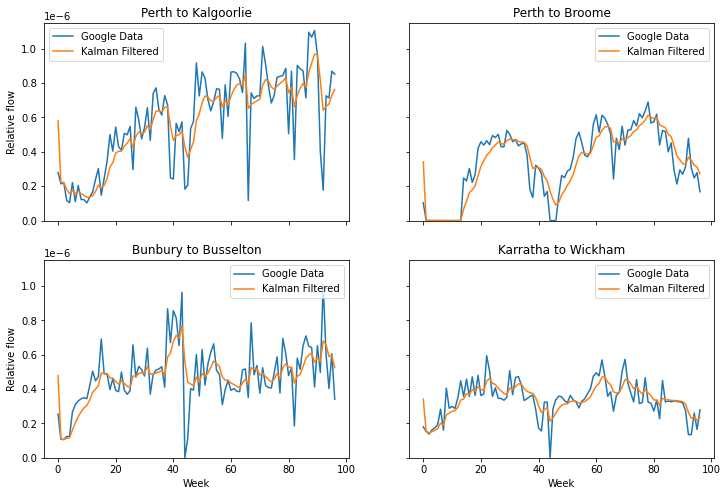

In [62]:
fig, axs = plt.subplots(2, 2,figsize = (12,8))
ts = timeseries_vector(3)
ts1 = timeseries_vector1(3)
axs[0, 0].plot(ts,label = 'Google Data')
axs[0, 0].plot(ts1, label = 'Kalman Filtered')
axs[0, 0].set_title('Perth to Kalgoorlie')
axs[0, 0].set_ylim(0,0.00000115)
axs[0, 0].legend()
ts = timeseries_vector(7)
ts1 = timeseries_vector1(7)
axs[0, 1].plot(ts,label = 'Google Data')
axs[0, 1].plot(ts1, label = 'Kalman Filtered')
axs[0, 1].set_title('Perth to Broome')
axs[0, 1].set_ylim(0,0.00000115)
axs[0, 1].legend()
ts = timeseries_vector(49)
ts1 = timeseries_vector1(49)
axs[1, 0].plot(ts,label = 'Google Data')
axs[1, 0].plot(ts1, label = 'Kalman Filtered')
axs[1, 0].set_title('Bunbury to Busselton')
axs[1, 0].set_ylim(0,0.00000115)
axs[1, 0].legend(loc = 'upper right')
ts = timeseries_vector(297)
ts1 = timeseries_vector1(297)
axs[1, 1].plot(ts,label = 'Google Data')
axs[1, 1].plot(ts1, label = 'Kalman Filtered')
axs[1, 1].set_title('Karratha to Wickham')
axs[1, 1].set_ylim(0,0.00000115)
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Week', ylabel='Relative flow')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## With Stochasticising

In [66]:
# For kalman filtered
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/44_towns_network/"))
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)
        
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44/"+wa_flow[i], header = None)

# Define some global variables
b = 44
big =44**2
weeks = len(d)

allvals1 = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals1.append(k)

#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector1(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals1[x+(big)*i])
    return timeseries

In [67]:
# For stochastic
# For kalman filtered
fl = sorted(os.listdir("/Volumes/HardDrive/New_Workflow/stochastic_44/"))
wa_flow = []
for item in fl:
    if '._' not in item:
        wa_flow.append(item)
        
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/stochastic_44/"+wa_flow[i], header = None)

# Define some global variables
b = 44
big =44**2
weeks = len(d)

allvals2 = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals2.append(k)

#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector2(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals2[x+(big)*i])
    return timeseries

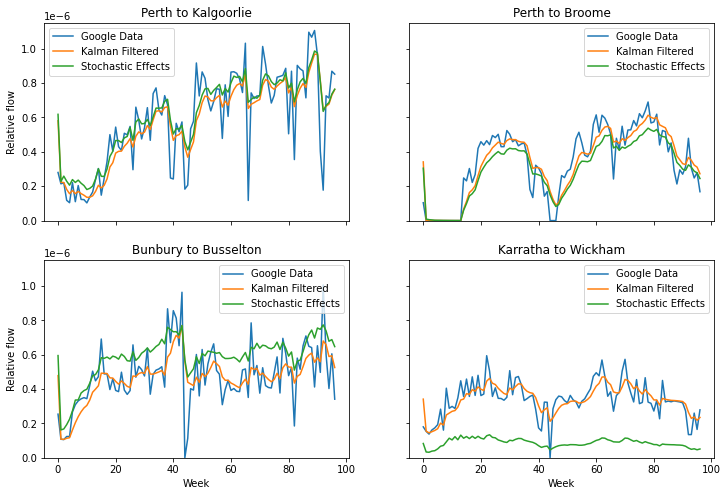

In [68]:
fig, axs = plt.subplots(2, 2,figsize = (12,8))
ts = timeseries_vector(3)
ts1 = timeseries_vector1(3)
ts2 = timeseries_vector2(3)
axs[0, 0].plot(ts,label = 'Google Data')
axs[0, 0].plot(ts1, label = 'Kalman Filtered')
axs[0, 0].plot(ts2, label = 'Stochastic Effects')
axs[0, 0].set_title('Perth to Kalgoorlie')
axs[0, 0].set_ylim(0,0.00000115)
axs[0, 0].legend()
ts = timeseries_vector(7)
ts1 = timeseries_vector1(7)
ts2 = timeseries_vector2(7)
axs[0, 1].plot(ts,label = 'Google Data')
axs[0, 1].plot(ts1, label = 'Kalman Filtered')
axs[0, 1].plot(ts2, label = 'Stochastic Effects')
axs[0, 1].set_title('Perth to Broome')
axs[0, 1].set_ylim(0,0.00000115)
axs[0, 1].legend()
ts = timeseries_vector(49)
ts1 = timeseries_vector1(49)
ts2 = timeseries_vector2(49)
axs[1, 0].plot(ts,label = 'Google Data')
axs[1, 0].plot(ts1, label = 'Kalman Filtered')
axs[1, 0].plot(ts2, label = 'Stochastic Effects')
axs[1, 0].set_title('Bunbury to Busselton')
axs[1, 0].set_ylim(0,0.00000115)
axs[1, 0].legend(loc = 'upper right')
ts = timeseries_vector(297)
ts1 = timeseries_vector1(297)
ts2 = timeseries_vector2(297)
axs[1, 1].plot(ts,label = 'Google Data')
axs[1, 1].plot(ts1, label = 'Kalman Filtered')
axs[1, 1].plot(ts2, label = 'Stochastic Effects')
axs[1, 1].set_title('Karratha to Wickham')
axs[1, 1].set_ylim(0,0.00000115)
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Week', ylabel='Relative flow')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [69]:
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/kalman_all_44/"+wa_flow[i], header = None)
    
counter = 0
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            if k >0:
                counter+=1
print(counter/97)

128.16494845360825


In [70]:
d = {}
for i in range(len(wa_flow)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/stochastic_44/"+wa_flow[i], header = None)
    
counter = 0
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            if k >0:
                counter+=1
print(counter/97)

1648.4329896907216


In [73]:
44**2-44

1892

In [57]:
max(allvals2)*8999716586

122824.49360710997

In [84]:
97*58*58

326308